In [ ]:
import os
import torch
torch.manual_seed(42) # Set arbitrary seed
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler # Needed to construct the validation set
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import itertools
np.random.seed(3) # Set arbitrary seed

In [ ]:
# Prepare the data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Transform images to tensors and normalise

# Download the data (comes as train and test sets)
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Select a subset of classes from the train and test sets to create Fashion-MNIST-1
idx = (trainset.targets==0) | (trainset.targets==1) | (trainset.targets==4) | (trainset.targets==5) | (trainset.targets==8)
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]
trainset.targets[trainset.targets==4] = 2
trainset.targets[trainset.targets==5] = 3
trainset.targets[trainset.targets==8] = 4

idx = (testset.targets==0) | (testset.targets==1) | (testset.targets==4) | (testset.targets==5) | (testset.targets==8)
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testset.targets[testset.targets==4] = 2
testset.targets[testset.targets==5] = 3
testset.targets[testset.targets==8] = 4

# Prepare the validation set from the train set (25k or 5/6ths images for train and 5k or 1/6th images for validation)
indices = list(range(len(trainset)))
np.random.shuffle(indices)
slice3 = 25000
train_data = SubsetRandomSampler(indices[:slice3]) # This will be the train dataset for Task 3.1
valid_data = SubsetRandomSampler(indices[slice3:]) # This will be the validation dataset for Task 3.1

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Shape formula is 
# Input n x n, padding of p, filter size of f, stride of s, then output shape is
# floor((n + 2p - f)/s) + 1

In [ ]:
# Define NN Classes
class Neural_Network5Conv(nn.Module):
    # CNN layers
    def __init__(self, activation = 'relu'):
        
        # Layers
        super(Neural_Network5Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size= 3) # no max pool here
        self.conv2 = nn.Conv2d(10, 20, kernel_size= 5) # max pool after here
        self.conv3 = nn.Conv2d(20, 30, kernel_size = 5) # max pool after here
        self.conv4 = nn.Conv2d(30, 20, kernel_size = 7)
        self.conv5 = nn.Conv2d(20, 10, kernel_size = 5)
        self.fc1 = nn.Linear(160, 5)
        self.activation = activation

        # Utitlities
        self.losses = []
        self.accuracies = []
        self.validlosses = []
        self.validaccuracies = []
        self.epoch_track = []

    def forward(self, x):
      layer_activations = []
      if self.activation == 'relu':
        x = self.conv1(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.conv2(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.conv3(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.conv4(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.conv5(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = F.max_pool2d(x,2)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      elif activation == 'tanh':
        x = self.conv1(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.conv2(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.conv3(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.conv4(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.conv5(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = F.max_pool2d(x,2)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      elif activation == 'sigmoid':
        x = self.conv1(x)
        x = F.sigmoid(x)
        layer_activations.append(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        layer_activations.append(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        layer_activations.append(x)
        x = self.conv4(x)
        x = F.sigmoid(x)
        layer_activations.append(x)
        x = self.conv5(x)
        x = F.sigmoid(x)
        layer_activations.append(x)
        x = F.max_pool2d(x,2)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

      elif activation == 'leaky_relu':
        x = self.conv1(x)
        x = F.leaky_relu(x)
        layer_activations.append(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        layer_activations.append(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        layer_activations.append(x)
        x = self.conv4(x)
        x = F.leaky_relu(x)
        layer_activations.append(x)
        x = self.conv5(x)
        x = F.leaky_relu(x)
        layer_activations.append(x)
        x = F.max_pool2d(x,2)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      return x, layer_activations

In [ ]:
# Define NN Classes
class Neural_Network3Conv(nn.Module):
    # CNN layers
    def __init__(self, activation = 'relu'):
        
        # Layers
        super(Neural_Network3Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size= 3) # no max pool here
        self.conv2 = nn.Conv2d(10, 20, kernel_size= 3) # max pool after here
        self.conv3 = nn.Conv2d(20, 20, kernel_size = 3) # max pool after here
        self.fc1 = nn.Linear(500, 5)
        self.activation = activation

        # Utitlities
        self.losses = []
        self.accuracies = []
        self.validlosses = []
        self.validaccuracies = []
        self.epoch_track = []

    def forward(self, x):
      layer_activations = []
      if self.activation == 'relu':
        x = self.conv1(x)
        layer_activations.append(x)
        x = F.relu(x)
        x = self.conv2(x)
        layer_activations.append(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        layer_activations.append(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      elif activation == 'tanh':
        x = self.conv1(x)
        layer_activations.append(x)
        x = F.tanh(x)
        x = self.conv2(x)
        layer_activations.append(x)
        x = F.tanh(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        layer_activations.append(x)
        x = F.tanh(x)
        x = F.max_pool2d(x,2)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      elif activation == 'sigmoid':
        x = self.conv1(x)
        layer_activations.append(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        layer_activations.append(x)
        x = F.sigmoid(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        layer_activations.append(x)
        x = F.sigmoid(x)
        x = F.max_pool2d(x,2)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

      elif activation == 'leaky_relu':
        x = self.conv1(x)
        layer_activations.append(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        layer_activations.append(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        layer_activations.append(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x,2)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      return x, layer_activations


In [ ]:
# Def general training function
def train_model(train_size, val_size, test_size, model, trainset, validset, no_epochs, reg_coeff = 0, lr = 0.01, optimizer = 'adam', momentum = 0.95):
        loss_func = nn.CrossEntropyLoss() # Define cross entropy loss
        if optimizer == 'SGD':
          optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
        elif optimizer == 'adam':
          optimizer = optim.Adam(model.parameters(), lr = lr)
        elif optimizer == 'RMSProp':
          optimizer = optim.RMSprop(model.parameters(), lr = lr, momentum = momentum)
          
        epoch = 1

        for epoch in range(no_epochs):

            current_epoch = epoch + 1
            model.epoch_track.append(current_epoch)

            current_loss = 0.0
            current_accuracy = 0.0

            valid_current_loss = 0.0
            valid_current_accuracy = 0.0
            
            # Training
            for batch_index, training_batch in enumerate(trainset, 0):

                l2_loss = 0.0
                inputs, labels = training_batch
                inputs, labels = Variable(inputs), Variable(labels)
                # inputs = np.clip(inputs, 0., 1.)
                inputs = inputs.to('cuda')
                optimizer.zero_grad()
                outputs,_ = model.forward(inputs)
                outputs = outputs.to('cpu')
                
                # Calculate loss and optimise
                for param in model.parameters():
                  l2_loss += torch.norm(param)**2
                loss_no_reg = loss_func(outputs, labels)
                loss = loss_no_reg + reg_coeff * l2_loss
                loss.backward()
                optimizer.step()
                current_loss += loss_no_reg.item()
                
                # Calculate accuracy
                pred_labels = torch.argmax(outputs,axis=1).data
                correct_pred = (pred_labels == labels).sum().item()

                current_accuracy += correct_pred

            print('[Epoch: %d] train loss: %.3f' % (epoch + 1, current_loss / len(trainset)))
            model.losses.append(current_loss / len(trainset))
            print('[Epoch: %d] train acc: %.3f' % (epoch + 1, current_accuracy / train_size))
            model.accuracies.append(current_accuracy / train_size)

            # Validation
            for batch_index, validation_batch in enumerate(validset, 0):
                valid_inputs, valid_labels = validation_batch
                valid_inputs, valid_labels = Variable(valid_inputs), Variable(valid_labels)
                # valid_inputs = np.clip(valid_inputs, 0., 1.)
                valid_inputs = valid_inputs.to('cuda')
                optimizer.zero_grad()
                valid_outputs,_ = model.forward(valid_inputs)
                valid_outputs = valid_outputs.to('cpu')
                
                # Calculate loss
                valid_loss = loss_func(valid_outputs, valid_labels)
                valid_current_loss += valid_loss.item()
                
                # Calculate accuracy
                valid_pred_labels = torch.argmax(valid_outputs,axis=1).data
                valid_correct_pred = (valid_pred_labels == valid_labels).sum().item()

                valid_current_accuracy += valid_correct_pred

            print('[Epoch: %d] val loss: %.3f' % (epoch + 1, valid_current_loss / len(validset)))
            model.validlosses.append(valid_current_loss / len(validset))
            print('[Epoch: %d] val acc: %.3f' % (epoch + 1, valid_current_accuracy / val_size))
            model.validaccuracies.append(valid_current_accuracy / val_size)

        print('End of training')

In [ ]:
def generate_pattern(model, im_size, lr, optimizer, n_steps, layer, channel, momentum = 0.95, initial_value = None):
      # Freeze All Parameters
      for param in model.parameters():
        param.require_grad = False
      
      # Input 'variable' TODO
      if initial_value is None:
        gen_img = torch.rand((1,1,im_size,im_size), dtype = torch.float32, requires_grad=True)
      else:
        gen_img = torch.tensor(initial_value.reshape(1,1, im_size,im_size), dtype= torch.float32, requires_grad=True)
      init_im = torch.clone(gen_img).detach().numpy()
      # Create Optimizer
      if optimizer == 'SGD':
        optimizer = optim.SGD([gen_img], lr = lr, momentum = momentum)
      elif optimizer == 'adam':
        optimizer = optim.Adam([gen_img], lr = lr)
      elif optimizer == 'RMSProp':
        optimizer = optim.RMSprop([gem_img], lr = lr, momentum = momentum)

      # Forward Pass TODO
      optimizer.zero_grad()
      for n in range(n_steps):
        # Forward Pass until conv layer layer (after relu), e.g. x = forward_l(gen_img, 'relu'). Shape of output = 1 x height x width x num_channels.
        # Extract channel from output, x_out = x[:, :, :, channel]
        inputs = torch.clip(gen_img, 0., 1.)
        _, activations = model.forward(inputs.to('cuda'))
        x_out = activations[layer][:,channel,:,:]

        # Average all outputs
        av_x = torch.mean(x_out) # over all elements

        # Create Loss
        loss = -av_x

        if n%1000 == 0:
          print(f"Step {n}")
          print(loss)

        # Create Backpropagation
        loss.backward()
        optimizer.step()

      return gen_img, init_im

In [ ]:
# Auxiliary function
def plot_loss_acc(loss, acc, title):
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(np.arange(len(loss)), loss,'r')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.grid()
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(np.arange(len(acc)), acc)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()
    best_epoch=np.argmax(acc)
    best_accuracy = max(acc)
    print('best_accuracy:',best_accuracy,'achieved at epoch:',best_epoch)

def concatenate_batches(all_data):
    nc, h, w = all_data[0][0].shape[1:]
    samples = np.zeros((1, nc, h, w)); labels = np.zeros((1))
    for batch_ind in range(len(all_data)):
        batch_samples = all_data[batch_ind][0]; batch_labels = all_data[batch_ind][1]
        samples = np.concatenate([samples, batch_samples.numpy()], axis = 0); labels = np.concatenate([labels, batch_labels.numpy()], axis = 0)

    return samples[1:], labels[1:]


In [ ]:
# Load the 3 datasets
batch_size = 4096
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_data, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_data, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
# 2nd Network
optimizer = 'adam'
activation = 'relu'
momentum = 0.95
no_epochs = 100
lr = 0.002
reg = 0.0002

# Create the CNN
net2 = Neural_Network5Conv(activation).to('cuda')

# Train the CNN
train_model(len(train_data), len(valid_data), len(testset), net2, trainloader, validloader, no_epochs, reg, lr, optimizer, momentum)

[Epoch: 1] train loss: 1.559
[Epoch: 1] train acc: 0.274
[Epoch: 1] val loss: 1.379
[Epoch: 1] val acc: 0.428
[Epoch: 2] train loss: 1.187
[Epoch: 2] train acc: 0.524
[Epoch: 2] val loss: 1.055
[Epoch: 2] val acc: 0.556
[Epoch: 3] train loss: 0.865
[Epoch: 3] train acc: 0.650
[Epoch: 3] val loss: 0.866
[Epoch: 3] val acc: 0.697
[Epoch: 4] train loss: 0.729
[Epoch: 4] train acc: 0.733
[Epoch: 4] val loss: 0.683
[Epoch: 4] val acc: 0.771
[Epoch: 5] train loss: 0.616
[Epoch: 5] train acc: 0.783
[Epoch: 5] val loss: 0.584
[Epoch: 5] val acc: 0.818
[Epoch: 6] train loss: 0.533
[Epoch: 6] train acc: 0.824
[Epoch: 6] val loss: 0.471
[Epoch: 6] val acc: 0.848
[Epoch: 7] train loss: 0.459
[Epoch: 7] train acc: 0.851
[Epoch: 7] val loss: 0.447
[Epoch: 7] val acc: 0.865
[Epoch: 8] train loss: 0.406
[Epoch: 8] train acc: 0.872
[Epoch: 8] val loss: 0.408
[Epoch: 8] val acc: 0.870
[Epoch: 9] train loss: 0.369
[Epoch: 9] train acc: 0.879
[Epoch: 9] val loss: 0.403
[Epoch: 9] val acc: 0.871
[Epoch: 10

In [ ]:
# Get full dataset
all_train_data = list(trainloader)

In [ ]:
train_samples, train_labels = concatenate_batches(all_train_data)

In [ ]:
# Get images of class
class_toget = 1; class_idx = train_labels == class_toget
train_samples_class = train_samples[class_idx,:,:,:]; #train_labels_class = train_labels[class_idx]

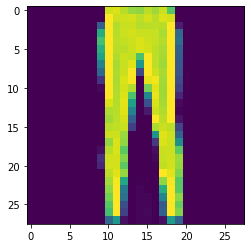

In [ ]:
# Get images of class
class_toget = 1; class_idx = train_labels == class_toget
train_samples_class = train_samples[class_idx,:,:,:]; #train_labels_class = train_labels[class_idx]
# Take one of the images
try_img = train_samples_class[0,:,:,:].reshape(1,1,28,28)
plt.imshow(try_img[0,0,:,:])

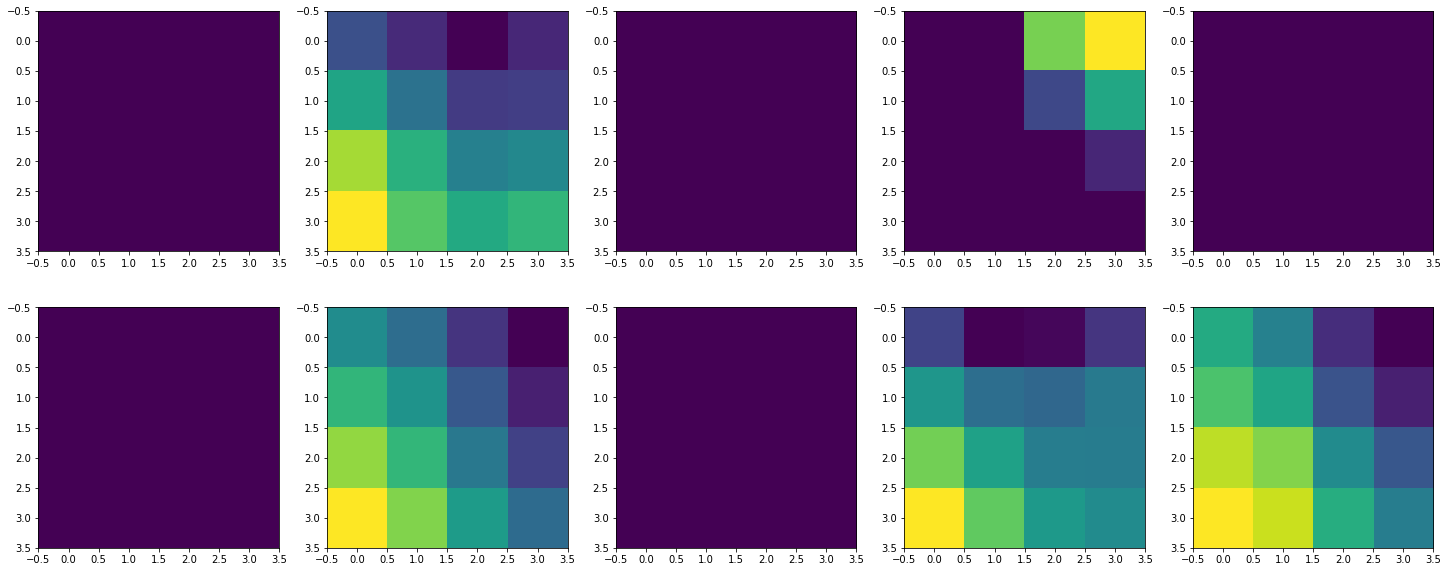

In [ ]:
# Print out the channel activations for a layer
layer = 5
try_tensor = torch.tensor(try_img, dtype = torch.float32).to('cuda')
_, activations = net2.forward(try_tensor)

channel_activations = activations[layer][0]
nChannel = activations[layer].shape[1]

fig,ax = plt.subplots(int(nChannel/5),5, figsize = (25, nChannel))

for ind in range(nChannel):
  row_ind = ind // 5; col_ind = ind % 5
  act_img = channel_activations[ind].detach().cpu().numpy()
  ax[row_ind][col_ind].imshow(act_img[:,:])

Step 0
tensor(-0.1748, device='cuda:0', grad_fn=<NegBackward>)
Step 1000
tensor(-0.1795, device='cuda:0', grad_fn=<NegBackward>)
Step 2000
tensor(-0.1795, device='cuda:0', grad_fn=<NegBackward>)
Step 3000
tensor(-0.1795, device='cuda:0', grad_fn=<NegBackward>)


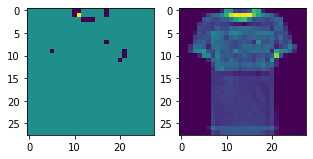

In [ ]:
gen_im, init_im = generate_pattern(net2, 28, 0.1, optimizer, 3001, 0, 2, initial_value=try_img[0,0,:,:])
gen_im_np = gen_im.detach().cpu().numpy()[0,0,:,:]
init_im_np = init_im[0,0,:,:]
fig, ax = plt.subplots(1,2, figsize = (5, 10))
ax[0].imshow(gen_im_np)
ax[1].imshow(init_im_np)

**TEST**

In [ ]:
# Define NN Classes
class Neural_Network5_v2Conv(nn.Module):
    # CNN layers
    def __init__(self, activation = 'relu'):
        
        # Layers
        super(Neural_Network5_v2Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, padding = 2, kernel_size= 3)
        self.conv2 = nn.Conv2d(10, 20, padding = 2, kernel_size= 3)
        self.conv3 = nn.Conv2d(20, 30, padding = 2, kernel_size = 3)
        self.conv4 = nn.Conv2d(30, 40, padding = 2, kernel_size = 3)
        self.conv5 = nn.Conv2d(40, 50, padding = 2, kernel_size = 3)
        self.fc1 = nn.Linear(200, 5)
        self.activation = activation
        self.pool = nn.MaxPool2d(2, 2)

        # Utitlities
        self.losses = []
        self.accuracies = []
        self.validlosses = []
        self.validaccuracies = []
        self.epoch_track = []

    def forward(self, x):
      layer_activations = []
      if self.activation == 'relu':
        x = self.conv1(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv2(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv3(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv4(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv5(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

      if self.activation == 'tanh':
        x = self.conv1(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv2(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv3(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv4(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv5(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      return x, layer_activations

In [ ]:
# Define NN Classes
class Neural_Network6_v2Conv(nn.Module):
    # CNN layers
    def __init__(self, activation = 'relu'):
        
        # Layers
        super(Neural_Network6_v2Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, padding = 1, kernel_size= 3)
        self.conv2 = nn.Conv2d(10, 20, padding = 1, kernel_size= 3)
        self.conv3 = nn.Conv2d(20, 30, padding = 1, kernel_size = 3)
        self.fc1 = nn.Linear(270, 5)
        self.activation = activation
        self.pool = nn.MaxPool2d(2, 2)

        # Utitlities
        self.losses = []
        self.accuracies = []
        self.validlosses = []
        self.validaccuracies = []
        self.epoch_track = []

    def forward(self, x):
      layer_activations = []
      if self.activation == 'relu':
        x = self.conv1(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv2(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv3(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

      if self.activation == 'tanh':
        x = self.conv1(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv2(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv3(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      return x, layer_activations

In [ ]:
# Define NN Classes
class Neural_Network4_v2Conv(nn.Module):
    # CNN layers
    def __init__(self, activation = 'relu'):
        
        # Layers
        super(Neural_Network4_v2Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, padding = 2, kernel_size= 3)
        self.conv2 = nn.Conv2d(10, 20, padding = 2, kernel_size= 3)
        self.conv3 = nn.Conv2d(20, 30, padding = 2, kernel_size = 3)
        self.conv4 = nn.Conv2d(30, 20, padding = 2, kernel_size = 3)
        self.fc1 = nn.Linear(180, 5)
        self.activation = activation
        self.pool = nn.MaxPool2d(2, 2)

        # Utitlities
        self.losses = []
        self.accuracies = []
        self.validlosses = []
        self.validaccuracies = []
        self.epoch_track = []

    def forward(self, x):
      layer_activations = []
      if self.activation == 'relu':
        x = self.conv1(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv2(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv3(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv4(x)
        x = F.relu(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

      if self.activation == 'tanh':
        x = self.conv1(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv2(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv3(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = self.conv4(x)
        x = F.tanh(x)
        layer_activations.append(x)
        x = self.pool(x)
        layer_activations.append(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
      
      return x, layer_activations

In [ ]:
optimizer = 'adam'
activation = 'relu'
momentum = 0.95
no_epochs = 100
lr = 0.002
reg = 0.0002

# Create the CNN
net3 = Neural_Network5_v2Conv(activation).to('cuda')

# Train the CNN
train_model(len(train_data), len(valid_data), len(testset), net3, trainloader, validloader, no_epochs, reg, lr, optimizer, momentum)

[Epoch: 1] train loss: 1.585
[Epoch: 1] train acc: 0.242
[Epoch: 1] val loss: 1.487
[Epoch: 1] val acc: 0.498
[Epoch: 2] train loss: 1.257
[Epoch: 2] train acc: 0.574
[Epoch: 2] val loss: 0.927
[Epoch: 2] val acc: 0.715
[Epoch: 3] train loss: 0.750
[Epoch: 3] train acc: 0.735
[Epoch: 3] val loss: 0.543
[Epoch: 3] val acc: 0.847
[Epoch: 4] train loss: 0.448
[Epoch: 4] train acc: 0.857
[Epoch: 4] val loss: 0.338
[Epoch: 4] val acc: 0.892
[Epoch: 5] train loss: 0.306
[Epoch: 5] train acc: 0.903
[Epoch: 5] val loss: 0.307
[Epoch: 5] val acc: 0.918
[Epoch: 6] train loss: 0.251
[Epoch: 6] train acc: 0.927
[Epoch: 6] val loss: 0.256
[Epoch: 6] val acc: 0.925
[Epoch: 7] train loss: 0.219
[Epoch: 7] train acc: 0.938
[Epoch: 7] val loss: 0.214
[Epoch: 7] val acc: 0.927
[Epoch: 8] train loss: 0.188
[Epoch: 8] train acc: 0.941
[Epoch: 8] val loss: 0.191
[Epoch: 8] val acc: 0.941
[Epoch: 9] train loss: 0.183
[Epoch: 9] train acc: 0.948
[Epoch: 9] val loss: 0.166
[Epoch: 9] val acc: 0.950
[Epoch: 10

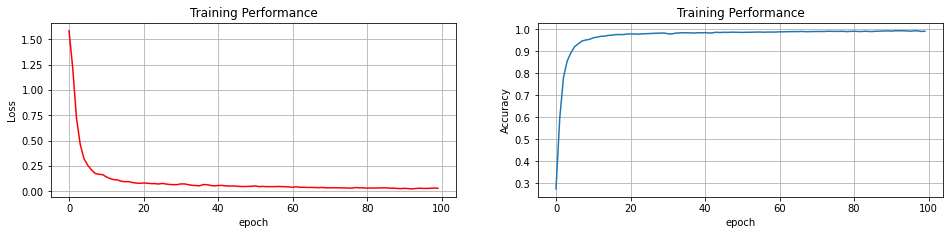

best_accuracy: 0.99316 achieved at epoch: 92


In [ ]:
plot_loss_acc(net3.losses, net3.accuracies, 'Training Performance')

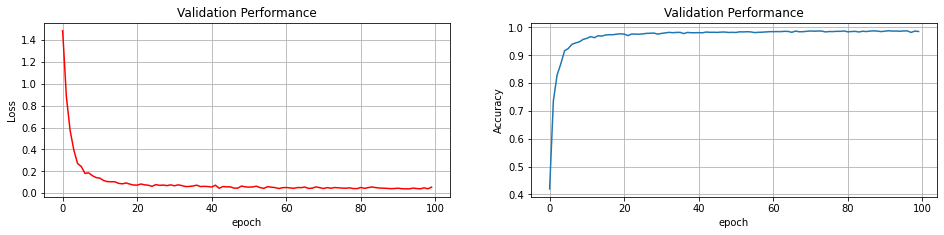

best_accuracy: 0.9882 achieved at epoch: 91


In [ ]:
plot_loss_acc(net3.validlosses, net3.validaccuracies, 'Validation Performance')

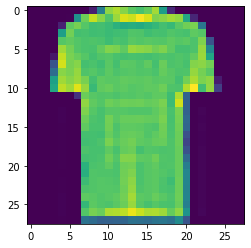

In [ ]:
# Get images of class
class_toget = 0; class_idx = train_labels == class_toget
train_samples_class = train_samples[class_idx,:,:,:]; #train_labels_class = train_labels[class_idx]
# Take one of the images
try_img = train_samples_class[0,:,:,:].reshape(1,1,28,28)
plt.imshow(try_img[0,0,:,:])

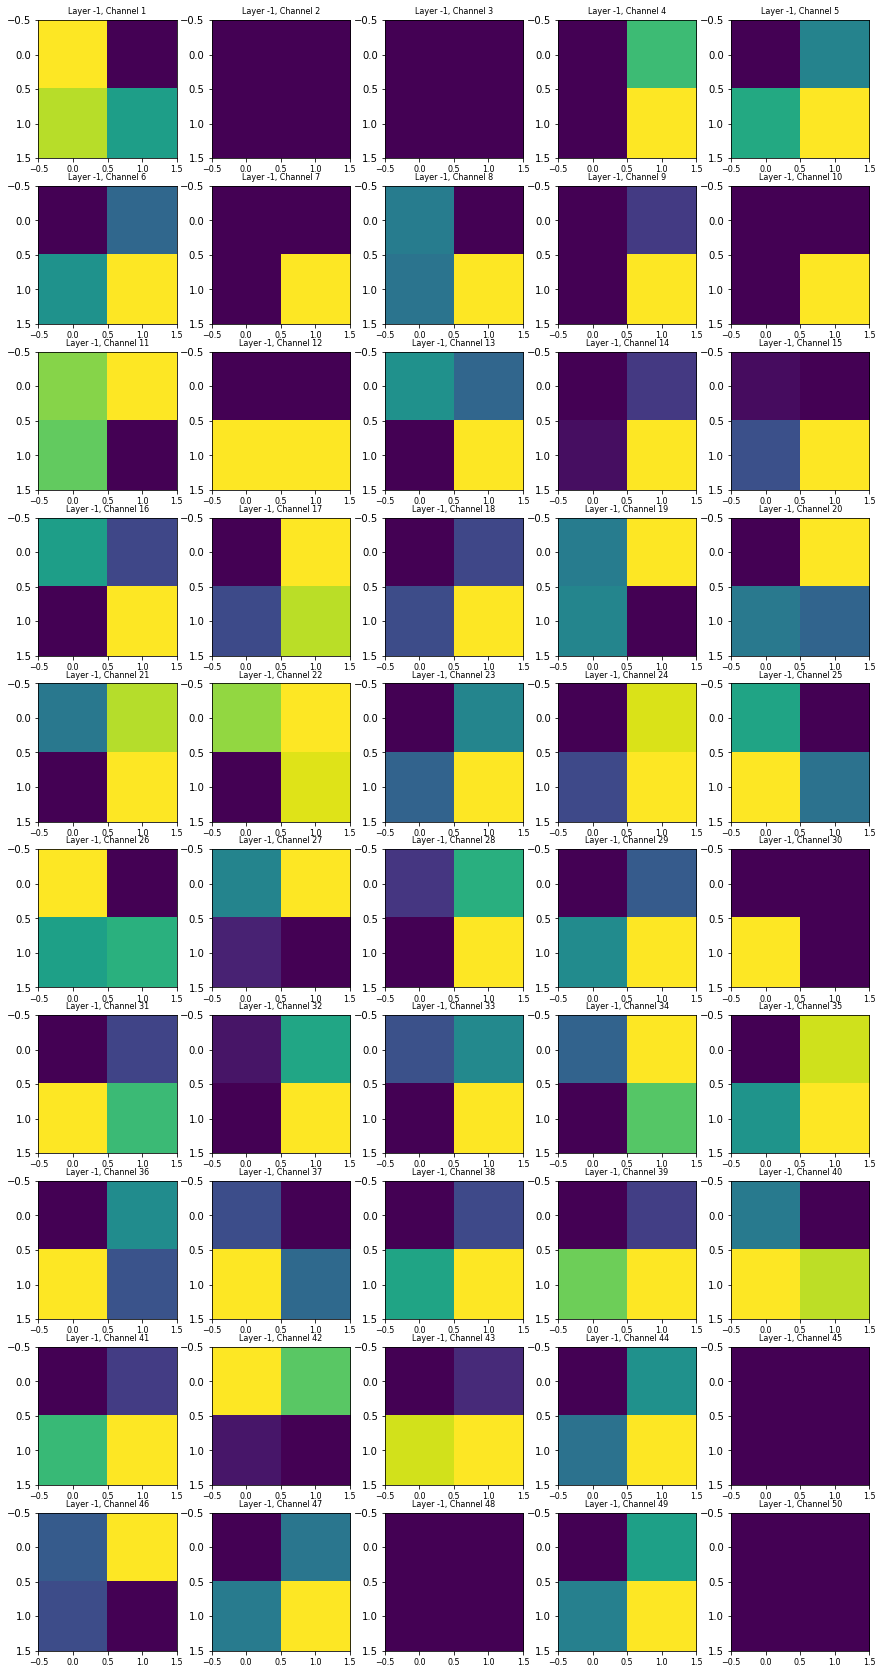

In [ ]:
# Print out the channel activations for a layer

layer = -1; ipr = 5; imw = 3
try_tensor = torch.tensor(try_img, dtype = torch.float32).to('cuda')
_, activations = net3.forward(try_tensor)

channel_activations = activations[layer][0]
nChannel = activations[layer].shape[1]

fig,ax = plt.subplots(int(nChannel/ipr), ipr, figsize = (ipr * imw, nChannel/ipr * imw))
# fig,ax = plt.subplots(1, ipr, figsize = (ipr * imw, imw))
for ind in range(nChannel):
  row_ind = ind // ipr; col_ind = ind % ipr
  act_img = channel_activations[ind].detach().cpu().numpy()
  ax[row_ind][col_ind].set_title(f'Layer {layer}, Channel {ind+1}', fontsize = 8)
  ax[row_ind][col_ind].imshow(act_img[:,:])
  ax[row_ind][col_ind].tick_params(axis = 'x', labelsize = 8)

# for ind in range(ipr):
#   row_ind = ind // ipr; col_ind = ind % ipr
#   act_img = channel_activations[ind].detach().cpu().numpy()
#   ax[col_ind].set_title(f'Layer {layer+1}, Channel {ind+1}', fontsize = 8)
#   ax[col_ind].imshow(act_img[:,:])
#   ax[col_ind].tick_params(axis = 'x', labelsize = 8)

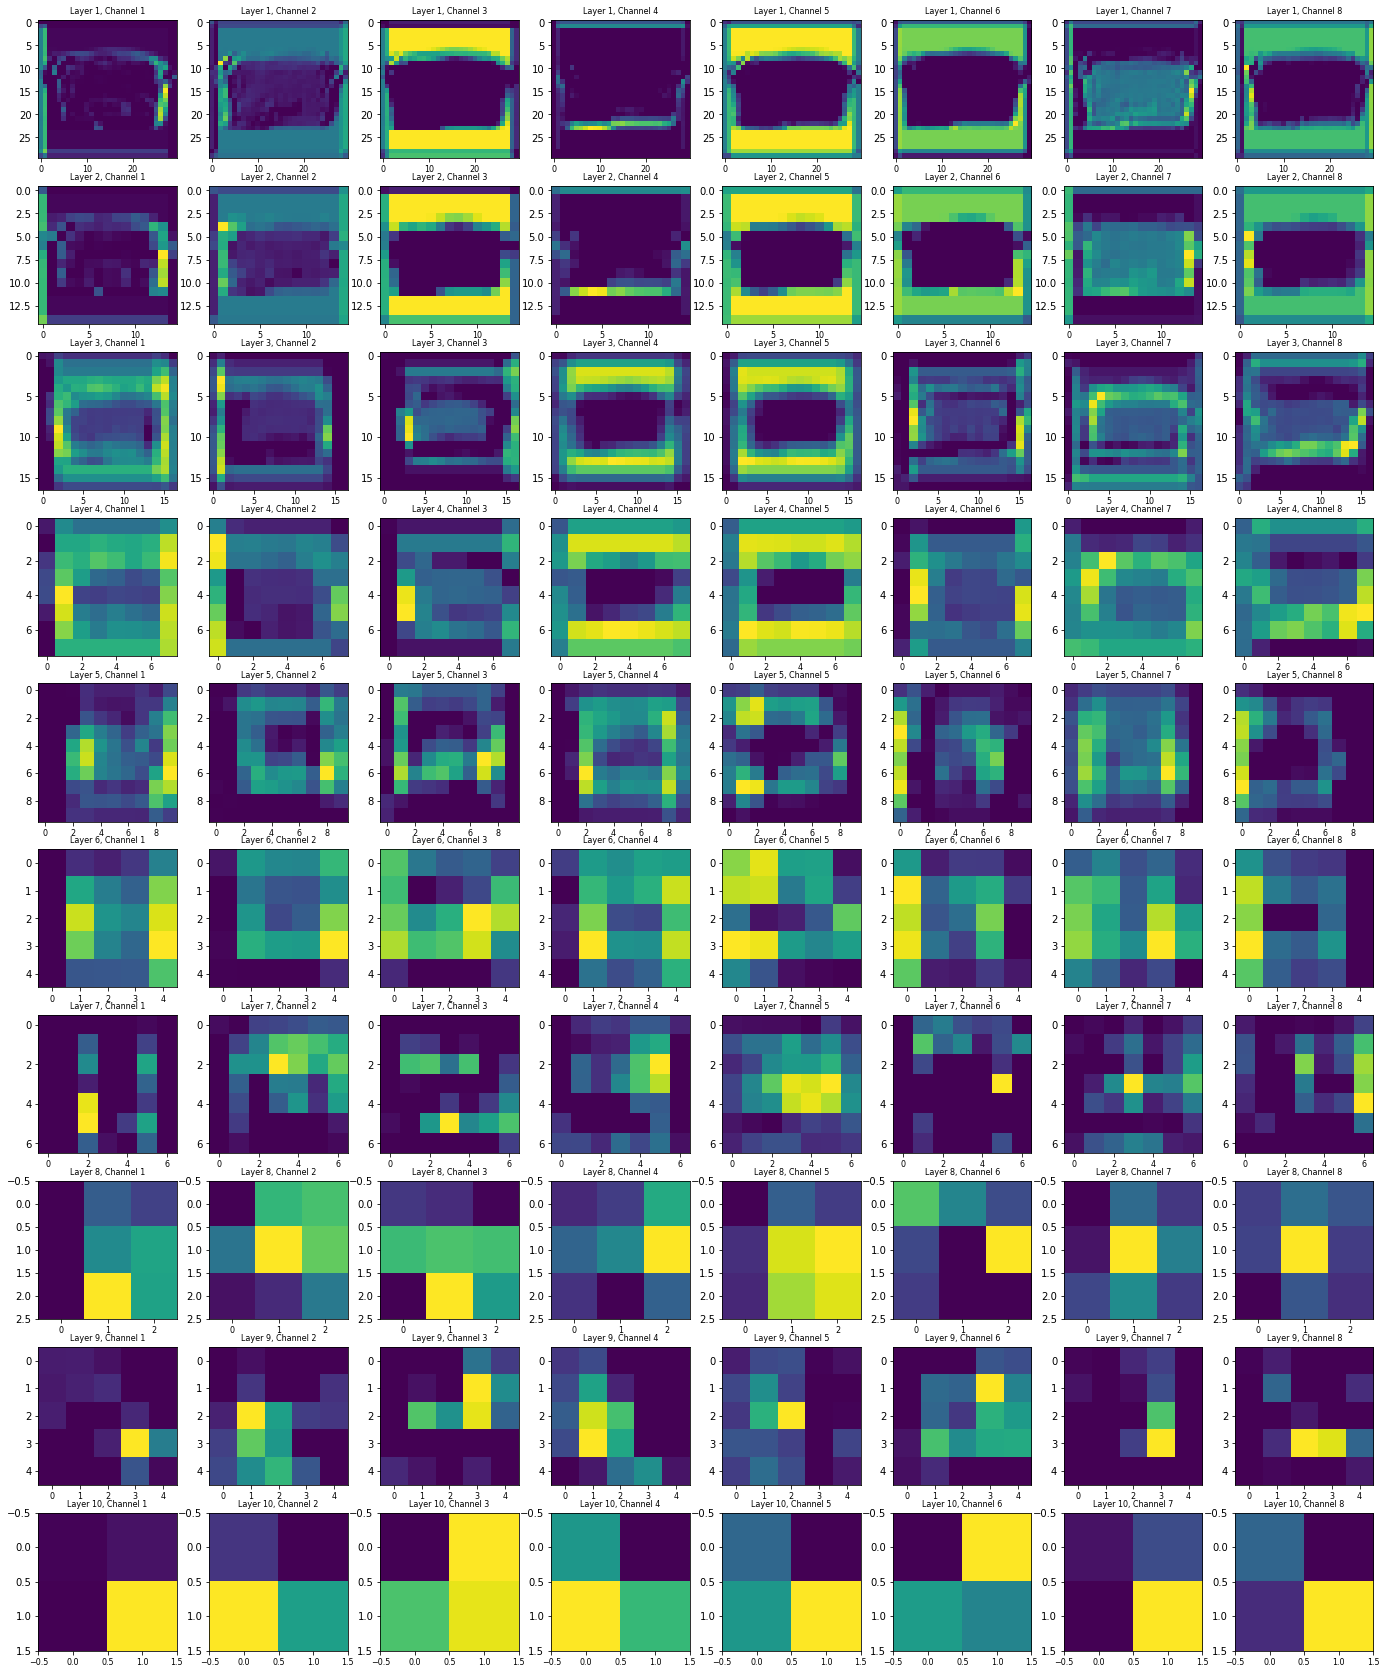

In [ ]:
nLayer = 10; ipr = 8; imw = 3
try_tensor = torch.tensor(try_img, dtype = torch.float32).to('cuda')
_, activations = net3.forward(try_tensor)
fig, ax = plt.subplots(nLayer, ipr, figsize = (ipr * imw, nLayer * imw))
for layer in range(nLayer):
    channel_activations = activations[layer][0]
    for ind in range(ipr):
      act_img = channel_activations[ind].detach().cpu().numpy()
      ax[layer][ind].set_title(f'Layer {layer+1}, Channel {ind+1}', fontsize = 8)
      ax[layer][ind].imshow(act_img[:,:])
      ax[layer][ind].tick_params(axis = 'x', labelsize = 8)